In [1]:
# https://zhuanlan.zhihu.com/p/1933167050701935613
# 准备数据
import yfinance as yf
import pandas as pd

stock = yf.Ticker("TSLA")
df = stock.history(period="1y")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-07-29 00:00:00-04:00,224.899994,234.270004,224.699997,232.100006,129201800,0.0,0.0
2024-07-30 00:00:00-04:00,232.250000,232.410004,220.000000,222.619995,100560300,0.0,0.0
2024-07-31 00:00:00-04:00,227.899994,234.679993,226.789993,232.070007,67497000,0.0,0.0
2024-08-01 00:00:00-04:00,227.690002,231.869995,214.330002,216.860001,83861900,0.0,0.0
2024-08-02 00:00:00-04:00,214.880005,216.130005,205.779999,207.669998,82880100,0.0,0.0


In [14]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

features = df.columns.drop(['Dividends', 'Stock Splits']).tolist()
print(f'特征列: {features}')
print('__' * 50)
features_np = df[features].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(features_np)
print(f'数据归一化后的形状: {data_scaled.shape}')
print('__' * 50)

def create_dataset(data, lookback:int=1):
    """
    将时间序列数据转换为监督学习格式
    :param data: 归一化后的数据，形状为 (n_samples, n_features)
    :param lookback: 用于预测的回溯步数
    :return: 输入序列 X 和目标序列 y
    """
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), :]) # 取当前点到 look_back 之前的序列作为 X
        y.append(data[i + lookback, -2])  # 取紧接着的下一个时间步的数据作为 y
    return np.array(X), np.array(y)

X_seq, y_seq = create_dataset(data_scaled, lookback=20)
print(f'输入序列 X 的形状: {X_seq.shape}=(样本数, 序列长度, 特征数)')
print(f'目标序列 y 的形状: {y_seq.shape}=(样本数,)')
print('__' * 50)

特征列: ['Open', 'High', 'Low', 'Close', 'Volume']
____________________________________________________________________________________________________
数据归一化后的形状: (250, 5)
____________________________________________________________________________________________________
输入序列 X 的形状: (230, 20, 5)=(样本数, 序列长度, 特征数)
目标序列 y 的形状: (230,)=(样本数,)
____________________________________________________________________________________________________


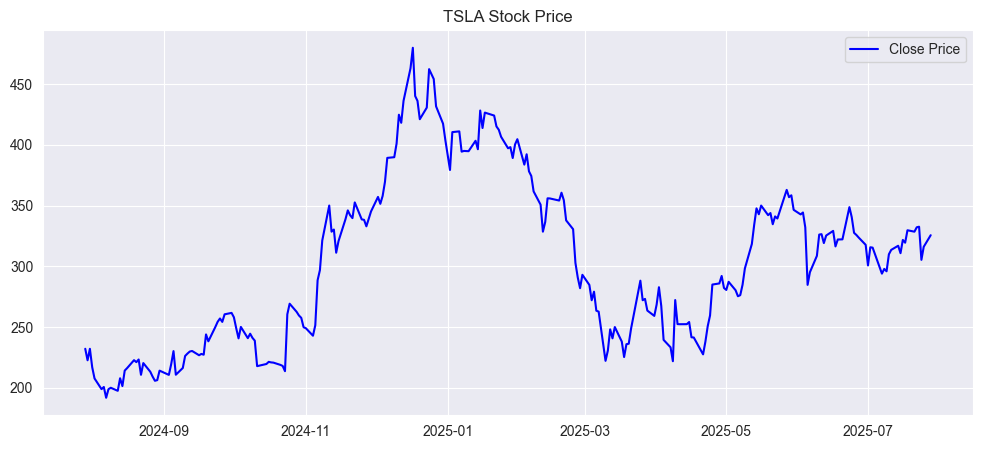

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('TSLA Stock Price')
plt.legend()
plt.show()

In [13]:
from utils import train_epoch
from torch import nn, optim
import torch


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x) # out: (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])  # 只取最后一个时间步的输出
        return out

learner_lstm = LSTMModel(input_size=X_seq.shape[2], hidden_size=64, num_layers=2)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
learner_lstm.to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(learner_lstm.parameters(), lr=0.001)

# 准备数据集
TRAIN_RATIO = 0.8
train_size = int(len(X_seq) * TRAIN_RATIO)
X_train, X_valid = X_seq[:train_size], X_seq[train_size:]
y_train, y_valid = y_seq[:train_size], y_seq[train_size:]
X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_valid = torch.tensor(X_valid, dtype=torch.float32).to(DEVICE)
y_train = torch.tensor(y_train, dtype=torch.float32).to(DEVICE)
y_valid = torch.tensor(y_valid, dtype=torch.float32).to(DEVICE)

array([0.13650748, 0.16179304, 0.14682811, 0.14610569, 0.10203662,
       0.        , 0.05342645, 0.05349526, 0.03605338, 0.04069768,
       0.0474749 , 0.04558277, 0.07626943, 0.06811615, 0.0892046 ,
       0.10957069, 0.13643871, 0.12883583, 0.1327921 , 0.10059174,
       0.11535021, 0.09642906, 0.08428513, 0.08456035, 0.08053531,
       0.10334386, 0.08727809, 0.13165682, 0.16299713, 0.10657767,
       0.11989131, 0.13530344, 0.13568186, 0.14717215, 0.15164443,
       0.15216044, 0.15436217, 0.1678134 , 0.19368379, 0.19743361,
       0.23689281, 0.23159486, 0.25932299, 0.24824551, 0.25395627,
       0.26644425, 0.21442825, 0.20386678, 0.21146967, 0.21941654,
       0.2007018 , 0.20159628, 0.19468143, 0.12009772, 0.12009772,
       0.11968486, 0.12446675, 0.12512039, 0.12209305, 0.11586622,
       0.1103963 , 0.10977709, 0.20455481, 0.24353244, 0.29166094,
       0.27277422, 0.25051606, 0.25034399, 0.22987475, 0.204142  ,
       0.21370578, 0.34212885, 0.35664654, 0.39190868, 0.55414